In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, DenseNet169, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Veri seti yolu
data_path = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR/Images'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

# Sanal bir test veri seti oluştur
fake_test_generator = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Early stopping için callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


def build_densenet169():
    densenet169_model = DenseNet169(include_top=False, input_shape=(224, 224, 3))
    for layer in densenet169_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(densenet169_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=80, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=5e-8),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def build_inceptionv3():
    inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
    for layer in inception_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=80, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=5e-8),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def build_vgg16():
    vgg16_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    for layer in vgg16_model.layers:
        layer.trainable = False

    model = models.Sequential()
    model.add(vgg16_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=80, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=2e-7),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



# Modelleri oluştur
densenet169_model = build_densenet169()
inceptionv3_model = build_inceptionv3()
vgg16_model = build_vgg16()

densenet169_history = densenet169_model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stopping])
inceptionv3_history = inceptionv3_model.fit(train_generator, validation_data=val_generator, epochs=30)
vgg16_history = vgg16_model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stopping])

Found 19200 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.
Found 4800 images belonging to 24 classes.
Epoch 1/30
600/600 [==============================] - 198s 311ms/step - loss: 3.5196 - accuracy: 0.0496 - val_loss: 3.2542 - val_accuracy: 0.0840
Epoch 2/30
600/600 [==============================] - 183s 306ms/step - loss: 3.2028 - accuracy: 0.0851 - val_loss: 3.0250 - val_accuracy: 0.1292
Epoch 3/30
600/600 [==============================] - 183s 305ms/step - loss: 2.9783 - accuracy: 0.1304 - val_loss: 2.8527 - val_accuracy: 0.1854
Epoch 4/30
600/600 [==============================] - 183s 306ms/step - loss: 2.8026 - accuracy: 0.1819 - val_loss: 2.7090 - val_accuracy: 0.2438
Epoch 5/30
600/600 [==============================] - 183s 305ms/step - loss: 2.6453 - accuracy: 0.2409 - val_loss: 2.5820 - val_accuracy: 0.2975
Epoch 6/30
600/600 [==============================] - 183s 305ms/step - loss: 2.5082 - accuracy: 0.2994 - val_loss: 2.4652 - val_accuracy: 0

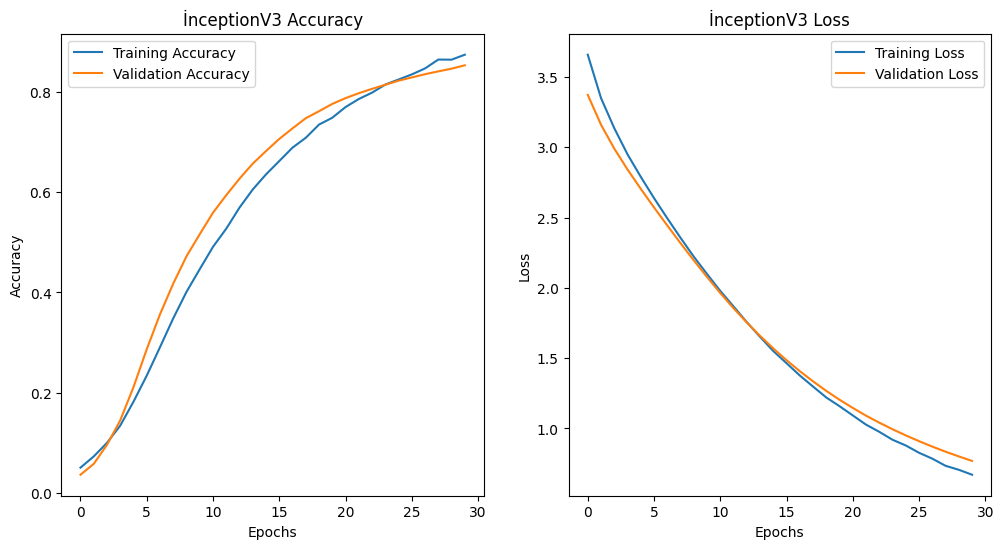

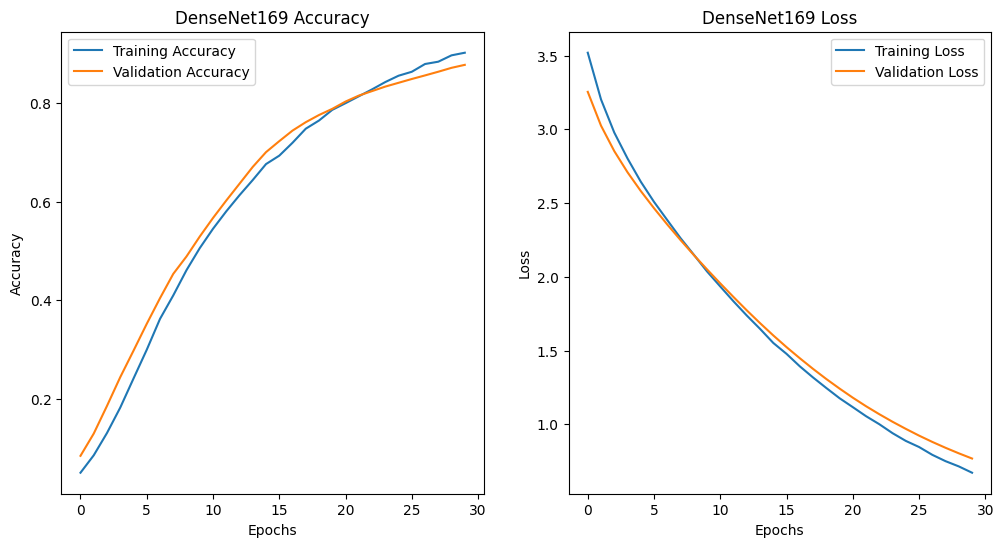

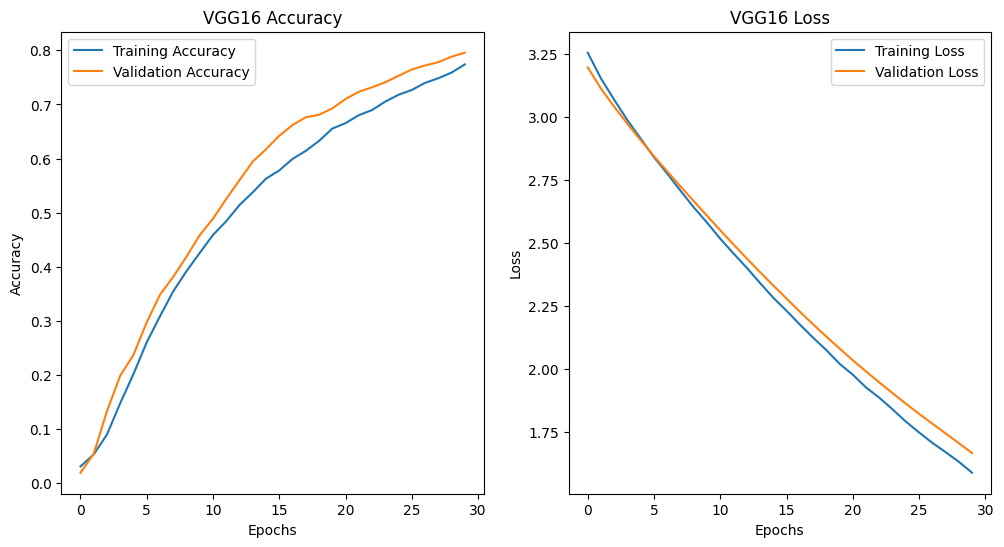

In [2]:
# Grafik çizimi
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Modellerin Eğitim Sonuçlarını Çiz
plot_history(inceptionv3_history, title='İnceptionV3')
plot_history(densenet169_history, title='DenseNet169')
plot_history(vgg16_history, title='VGG16')


In [3]:
# Test seti etiketlerini yükle
fake_test_labels = fake_test_generator.classes

# Modelleri ensemble etme
models = [inceptionv3_model, densenet169_model, vgg16_model]  
weights = [0.3, 0.5, 0.2]  # Ağırlıklar

# Ensemble tahminlerini ağırlıklı olarak oluşturma
predictions_list = []
for model in models:
    predictions = model.predict(fake_test_generator, verbose=1)
    predictions_list.append(predictions)

weighted_predictions = np.zeros_like(predictions_list[0])
for predictions, weight in zip(predictions_list, weights):
    weighted_predictions += predictions * weight

ensemble_labels = np.argmax(weighted_predictions, axis=1)

# Toplam tahmin sayısına göre bir matris oluştur
ensemble_predictions = np.zeros((fake_test_generator.samples, 24))  # 24 sınıf için

# Tahminleri ve ağırlıkları kullanarak toplam tahmini hesapla
for predictions, weight in zip(predictions_list, weights):
    ensemble_predictions += predictions * weight

# Final tahminler (en yüksek skoru olan sınıfın indeksini al)
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Performans metriklerini hesapla
accuracy_weighted = accuracy_score(fake_test_labels, final_predictions)
recall_weighted = recall_score(fake_test_labels, final_predictions, average='macro')
precision_weighted = precision_score(fake_test_labels, final_predictions, average='macro')
# Ensemble için F1 skorunu formülle hesapla
f1_weighted_direct = 2 * (precision_weighted * recall_weighted) / (precision_weighted + recall_weighted + 1e-15)

print(f'Ensemble Accuracy: {accuracy_weighted}')
print(f'Ensemble Recall: {recall_weighted}')
print(f'Ensemble Precision: {precision_weighted}')
print(f'Ensemble F1 Score: {f1_weighted_direct}')

# Her bir modelin ayrı ayrı değerlendirmesi
def evaluate_model(model, model_name):
    predictions = model.predict(fake_test_generator)
    predictions_classes = np.argmax(predictions, axis=1)
    f1 = 2 * (precision_score(fake_test_labels, predictions_classes, average='macro') * recall_score(fake_test_labels, predictions_classes, average='macro')) / (precision_score(fake_test_labels, predictions_classes, average='macro') + recall_score(fake_test_labels, predictions_classes, average='macro') + 1e-15)
    evaluation = model.evaluate(fake_test_generator)
    print(f"\n{model_name} Model Değerlendirmesi:")
    print("Loss:", evaluation[0])
    print("Accuracy:", evaluation[1])
    print("Precision:", precision_score(fake_test_labels, predictions_classes, average='macro'))
    print("Recall:", recall_score(fake_test_labels, predictions_classes, average='macro'))
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(fake_test_labels, predictions_classes))

evaluate_model(inceptionv3_model, "InceptionV3")
evaluate_model(densenet169_model, "DenseNet169")
evaluate_model(vgg16_model, "VGG16")


150/150 [==============================] - 38s 255ms/step
Ensemble Accuracy: 0.9216666666666666
Ensemble Recall: 0.9216666666666665
Ensemble Precision: 0.9280736173134475
Ensemble F1 Score: 0.9248590461035296
150/150 [==============================] - 21s 140ms/step - loss: 0.7683 - accuracy: 0.8523

InceptionV3 Model Değerlendirmesi:
Loss: 0.768311083316803
Accuracy: 0.8522916436195374
Precision: 0.8739365001939864
Recall: 0.8522916666666668
F1 Score: 0.8629783832872571
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.73      0.57      0.64       200
           2       0.96      0.94      0.95       200
           3       0.87      0.59      0.71       200
           4       0.99      0.99      0.99       200
           5       0.67      0.92      0.77       200
           6       0.98      1.00      0.99       200
           7       1.00      1.00      1.00       200
           8  

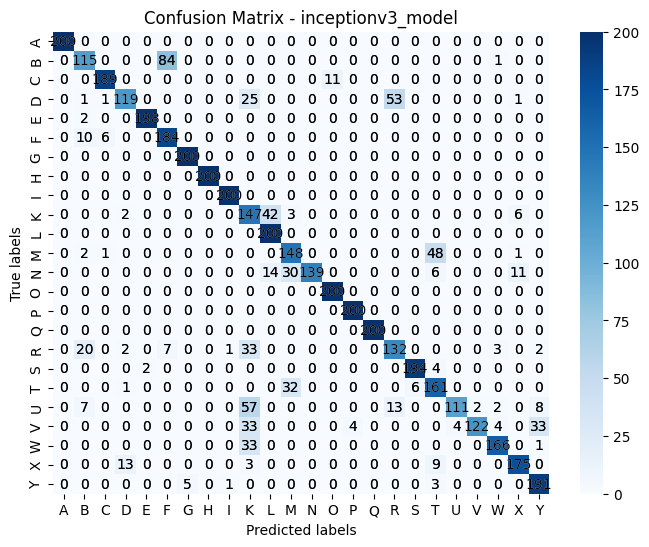

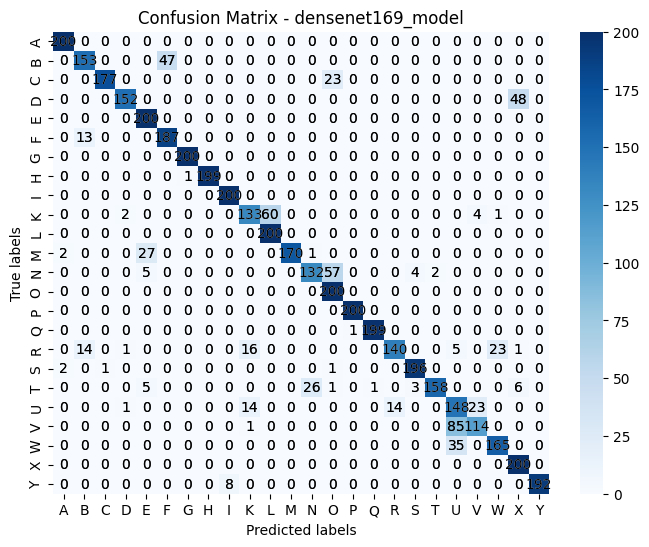

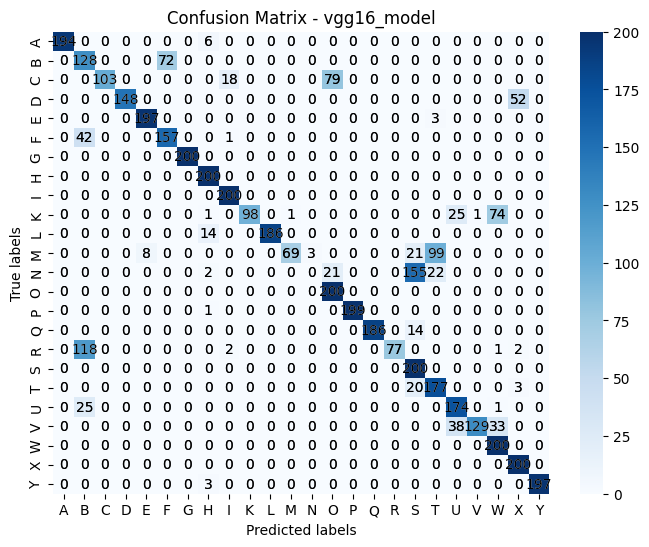

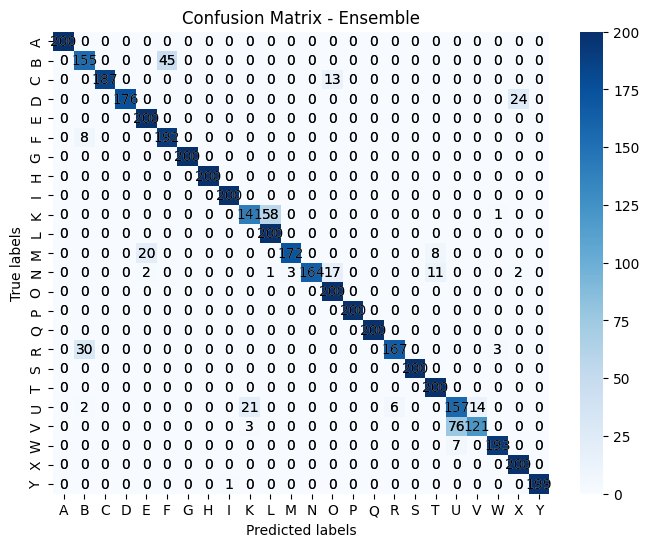

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_names = ['inceptionv3_model', 'densenet169_model','vgg16_model']
for idx, predictions in enumerate(predictions_list):
    cm = confusion_matrix(val_generator.classes, np.argmax(predictions, axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_names[idx]}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    for i in range(len(val_generator.class_indices)):
        for j in range(len(val_generator.class_indices)):
            plt.text(j+0.5, i+0.5, cm[i, j], ha='center', va='center', color='black')
    plt.show()

# Ensemble learning için confusion matrix oluştur
ensemble_cm = confusion_matrix(val_generator.classes, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, cmap='Blues', annot=True, fmt='d', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
for i in range(len(val_generator.class_indices)):
    for j in range(len(val_generator.class_indices)):
        plt.text(j+0.5, i+0.5, ensemble_cm[i, j], ha='center', va='center', color='black')
plt.show()




1/1 [==============================] - 0s 25ms/step


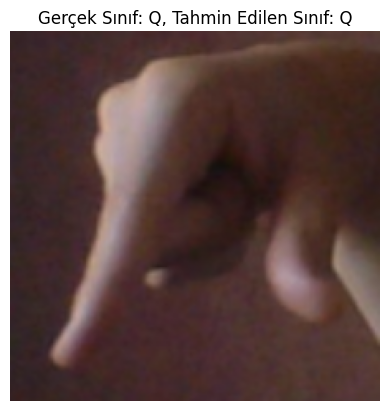

1/1 [==============================] - 0s 26ms/step


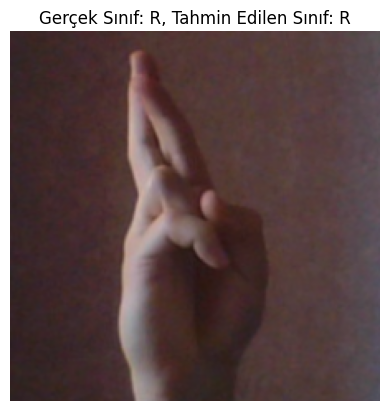

1/1 [==============================] - 0s 24ms/step


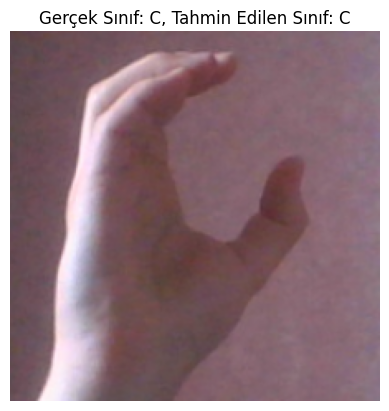

1/1 [==============================] - 0s 24ms/step


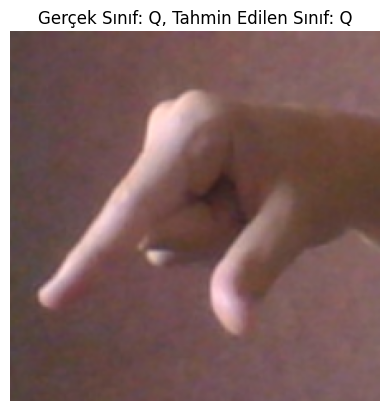

1/1 [==============================] - 0s 24ms/step


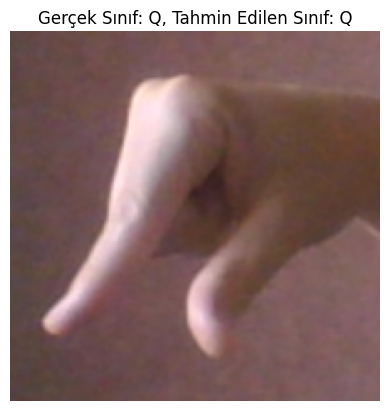

1/1 [==============================] - 0s 28ms/step


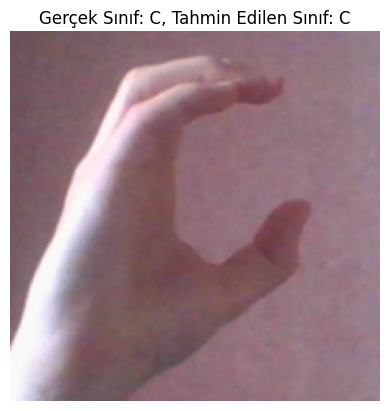

1/1 [==============================] - 0s 25ms/step


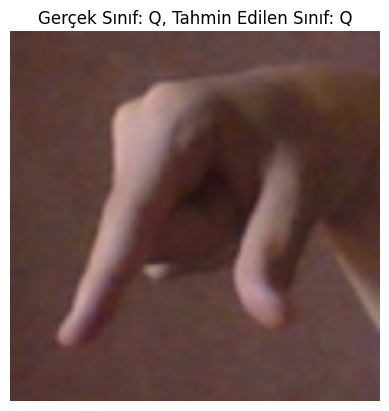

1/1 [==============================] - 0s 28ms/step


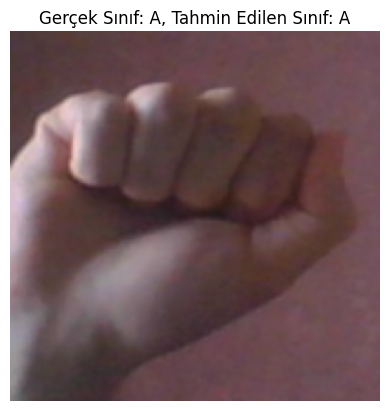

1/1 [==============================] - 0s 26ms/step


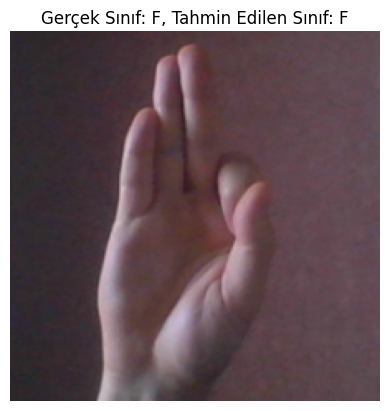

1/1 [==============================] - 0s 27ms/step


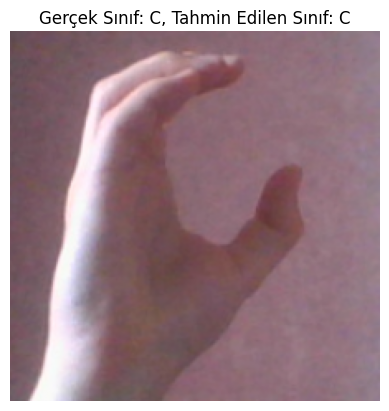

Toplam doğruluk: 1.0
1/1 [==============================] - 0s 29ms/step


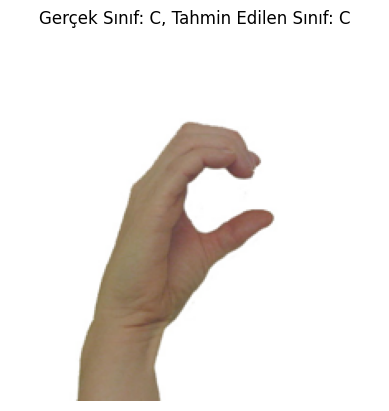

1/1 [==============================] - 0s 25ms/step


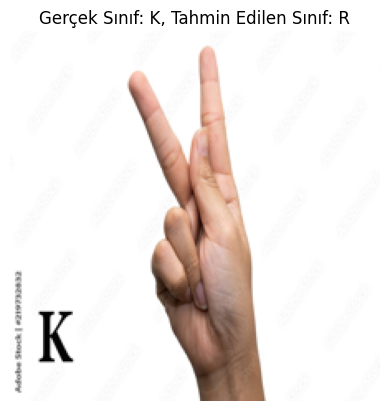

1/1 [==============================] - 0s 25ms/step


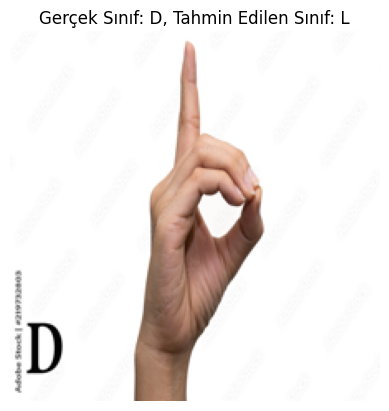

1/1 [==============================] - 0s 23ms/step


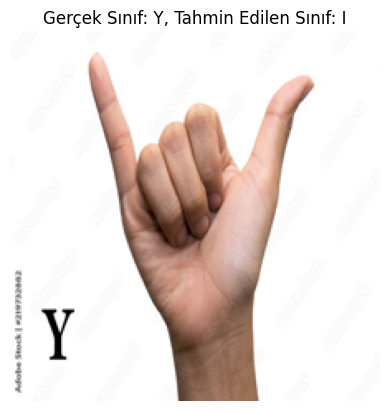

1/1 [==============================] - 0s 23ms/step


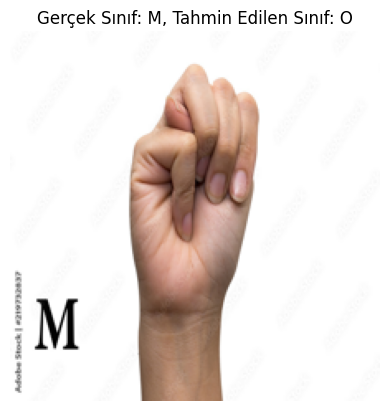

In [9]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

# Sınıf isimlerini al
class_names = list(fake_test_generator.class_indices.keys())

# Rastgele 10 görüntü seçme
random_image_paths = random.sample(fake_test_generator.filepaths, 10)

# Gerçek etiketleri ve tahminleri tutacak listeler
true_labels = []
predicted_labels = []

# Seçilen rastgele görüntüler için tahminler yapma
for image_path in random_image_paths:
    # Görüntüyü yükleme
    image = Image.open(image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Gerçek etiketi alarak isme dönüştürme
    true_label_index = fake_test_generator.classes[fake_test_generator.filepaths.index(image_path)]
    true_label = class_names[true_label_index]  # Gerçek etiketi isme dönüştürme

    # Gerçek ve tahmin edilen etiketleri listelere ekleme
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()

# Doğruluk hesaplama
accuracy = accuracy_score(true_labels, predicted_labels)
print("Toplam doğruluk:", accuracy)

# Kullanıcı tarafından belirlenen iki özel görüntü
base_dir = 'C:/Users/Andac/Desktop/VERİSETLERİVE KODLAR'  # Dosya yolunu burada belirleyin

custom_image_paths = [
    os.path.join(base_dir, "C.jpg"),
    os.path.join(base_dir, "K.jpg"),
    os.path.join(base_dir, "D.jpg"),
    os.path.join(base_dir, "Y.jpg"),
    os.path.join(base_dir, "M.jpg")
]
custom_true_labels = ["C", "K", "D","Y","M"]  # Bu etiketleri gerçek sınıflarla güncelleyin

# Özel görüntüler için tahminler yapma
for custom_image_path, custom_true_label in zip(custom_image_paths, custom_true_labels):
    # Görüntü yolunun var olup olmadığını kontrol etme
    if not os.path.exists(custom_image_path):
        print(f"Dosya bulunamadı: {custom_image_path}")
        continue
    
    # Görüntüyü yükleme
    image = Image.open(custom_image_path)
    
    # Dört kanallı görüntüyü üç kanallıya dönüştürme
    image = image.convert('RGB')

    # Görüntüyü model için uygun boyuta yeniden boyutlandırma ve normalizasyon
    image = image.resize((224, 224))  # Model için gerekli boyuta yeniden boyutlandırma
    image = np.array(image) / 255.0  # Normalizasyon

    # Tahmin yapma
    predictions = np.zeros((1, len(class_names)))  # Ensemble model için tahmin matrisi oluşturma
    for model, weight in zip(models, weights):
        prediction = model.predict(np.expand_dims(image, axis=0)) * weight
        predictions += prediction

    # En yüksek skoru olan sınıfın indeksini alarak tahmin etiketini bulma
    predicted_label_index = np.argmax(predictions)
    predicted_label = class_names[predicted_label_index]  # Tahmin edilen etiketi isme dönüştürme

    # Görüntüyü ekrana bastırma
    plt.imshow(image)
    plt.title(f"Gerçek Sınıf: {custom_true_label}, Tahmin Edilen Sınıf: {predicted_label}")
    plt.axis('off')
    plt.show()